In [2]:
import cvxportfolio as cvp
import pandas as pd
import numpy as np

In [18]:
my_fact_returns = pd.read_csv('cvxportfolio_fact_returns', index_col='Date')
my_fact_returns.index = pd.DatetimeIndex(my_fact_returns.index).tz_localize('UTC')

my_pred_returns = pd.read_csv('cvxportfolio_pred_returns', index_col='Date')
my_pred_returns.index = pd.DatetimeIndex(my_pred_returns.index).tz_localize('UTC')

my_fact_closes = pd.read_csv('cvxportfolio_fact_closes', index_col='Date')
my_fact_closes.index = pd.DatetimeIndex(my_fact_closes.index).tz_localize('UTC')

my_fact_opens = pd.read_csv('cvxportfolio_fact_opens', index_col='Date')
my_fact_opens.index = pd.DatetimeIndex(my_fact_opens.index).tz_localize('UTC')

universe_selector = my_fact_returns.notna() & my_fact_opens.notna()

returns_for_cov = my_fact_returns.copy()
for i in list(returns_for_cov.columns):
    returns_for_cov[i] = returns_for_cov[i].fillna(returns_for_cov[i].mean())
SIGMA = np.cov( returns_for_cov.to_numpy().T )#????????
SIGMA = pd.DataFrame(SIGMA, columns=my_pred_returns.columns).set_index(my_pred_returns.columns)

In [19]:
provided_data = cvp.UserProvidedMarketData(returns=my_fact_returns,
                                           prices=my_fact_opens,
                                           min_history=pd.Timedelta('1d'),
                                           universe_selection_in_time=universe_selector)

In the user-provided returns, assets Index(['AFLT', 'AGRO', 'ALRS', 'CBOM', 'CHMF', 'ENPG', 'FEES', 'FIVE', 'GAZP',
       'GLTR', 'GMKN', 'HYDR', 'IRAO', 'OZON', 'POLY', 'SGZH', 'VKCO'],
      dtype='object') seem to have incorrect missing values structure. For each asset, missing returns should only be at the start and/or at the end. You should use universe_selection_in_time if you wanted to specify changes of universe in time.


In [20]:
market = cvp.MarketSimulator(returns = my_fact_returns,
                    prices = my_fact_opens,
                    datasource = provided_data,
                    min_history = pd.Timedelta('1d'),
                    market_data = provided_data,
                    costs=[cvp.TransactionCost(a=0.0001)],
                    round_trades=True)

In [47]:
objective =cvp.ReturnsForecast(r_hat=my_pred_returns)-1*cvp.FullCovariance(SIGMA)-cvp.TransactionCost(a=0.0001)
constraints = [ cvp.LongOnly(applies_to_cash=True), cvp.LeverageLimit(1) ]

policy = cvp.SinglePeriodOptimization(objective, constraints)

In [49]:
backtest_res = market.backtest(policy)

In [50]:
backtest_res


#################################################################
Universe size                                                  43
Initial timestamp                       2023-02-03 17:00:00+00:00
Final timestamp                         2023-10-24 18:45:00+00:00
Number of periods                                            1641
Initial value (USDOLLAR)                                1.000e+06
Final value (USDOLLAR)                                  1.720e+05
Profit (USDOLLAR)                                      -8.280e+05
                                                                 
Avg. return (annualized)                                   -34.4%
Volatility (annualized)                                    206.4%
Avg. excess return (annualized)                            -39.3%
Avg. active return (annualized)                            -39.3%
Excess volatility (annualized)                             206.4%
Active volatility (annualized)                             206.4%
         

/home/daniil/anaconda3/lib/python3.11/site-packages/cvxportfolio/result.py:993: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show() # pragma: no cover


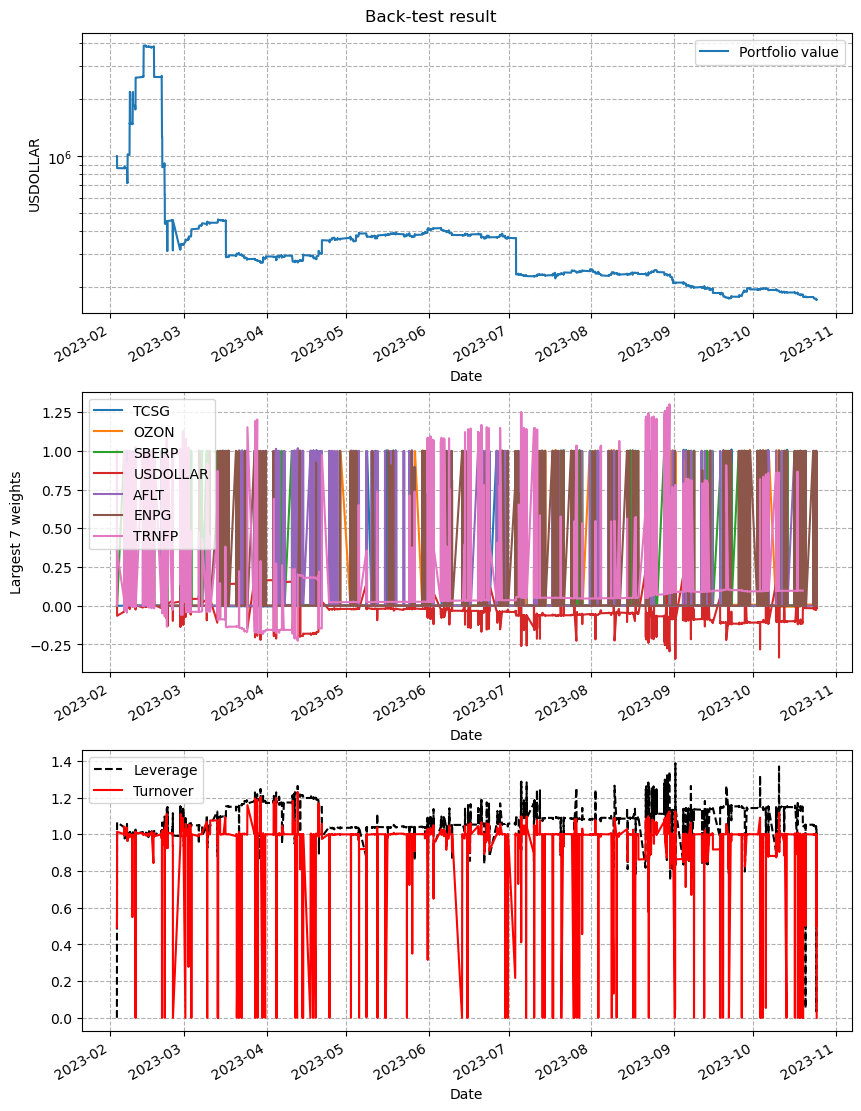

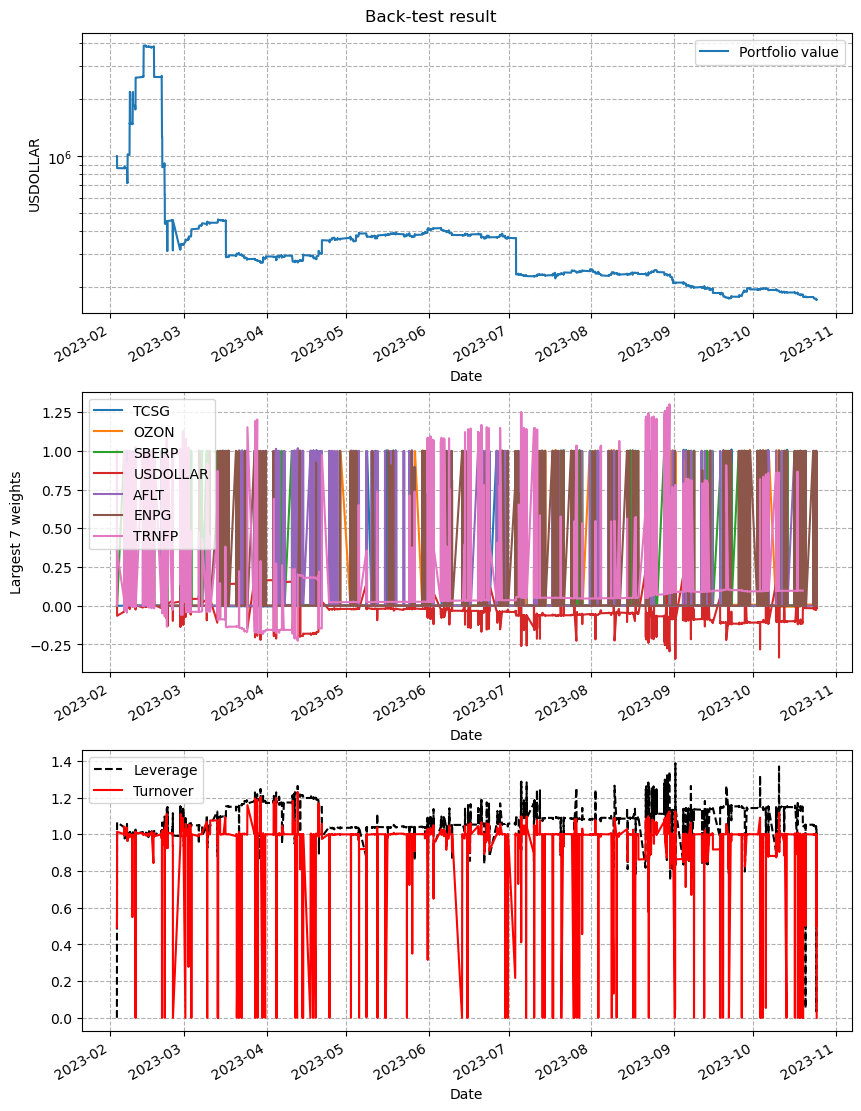

In [55]:
backtest_res.plot()